In [1]:
using SpectralUnmixing
using Plots
#using KernelDensity
#using StatsPlots
using Statistics

# Library Preparation

Start by leading up a library, filtering it down to the relevant classes, and interpolating to the relevant wavelengths

In [2]:
#endmember_library = SpectralLibrary("convex_hull__n_dims_4_unmix_library.csv", "level_1", 8, 0, ["soil","npv","pv"], 1.0, [[0,2000], [2440,2880]])
endmember_library = SpectralLibrary("convex_hull__n_dims_4_unmix_library.csv", "level_1", 8, 0, ["soil","npv","pv"], 1.0)

load_data!(endmember_library)
filter_by_class!(endmember_library)
			
refl_file_wl = read_envi_wavelengths("subset_npv")
interpolate_library_to_new_wavelengths!(endmember_library, refl_file_wl)

remove_wavelength_region_inplace!(endmember_library, true);

In [10]:
base_library = SpectralLibrary("convex_hull__n_dims_4_unmix_library_modified.csv", "level_1", 8, 0, ["soil","npv","pv"])
water_library = SpectralLibrary("emit_water_library.csv", "level_1", 5, 0, [ "water"])
aviris_library = SpectralLibrary("aviris1_pixel.csv", "level_1", 2, 0, [ "mixed"])

load_data!(base_library)
filter_by_class!(base_library)

load_data!(water_library)
filter_by_class!(water_library)

load_data!(aviris_library)
filter_by_class!(aviris_library)

# interpolating water_simulation library
interpolate_library_to_new_wavelengths!(water_library, base_library.wavelengths) # linear interpolation 

# merge libraries
merged_library = deepcopy(base_library)
merged_library.spectra = vcat(merged_library.spectra, water_library.spectra);
merged_library.classes = vcat(merged_library.classes, water_library.classes);
merged_library.class_valid_keys = unique(merged_library.classes)

# interpolating to emit wavelengths
emit_wl = read_envi_wavelengths("fake_refl")
interpolate_library_to_new_wavelengths!(merged_library, emit_wl) # linear interpolation 
interpolate_library_to_new_wavelengths!(aviris_library, emit_wl) # linear interpolation 

set_nans_to_zero!(merged_library)

remove_wavelength_region_inplace!(merged_library, true); # true = good for graphs
remove_wavelength_region_inplace!(aviris_library, true); # true = good for graphs

┌ Info: Ignoring wavelength regions: Any[[0, 440], [1310, 1490], [1770, 2050], [2440, 2880]]
└ @ SpectralUnmixing /Users/feifeiz/SpectralUnmixing-main/src/EndmemberLibrary.jl:110
┌ Info: Ignoring wavelength regions: Any[[0, 440], [1310, 1490], [1770, 2050], [2440, 2880]]
└ @ SpectralUnmixing /Users/feifeiz/SpectralUnmixing-main/src/EndmemberLibrary.jl:110
┌ Info: Ignoring wavelength regions: Any[[0, 440], [1310, 1490], [1770, 2050], [2440, 2880]]
└ @ SpectralUnmixing /Users/feifeiz/SpectralUnmixing-main/src/EndmemberLibrary.jl:110


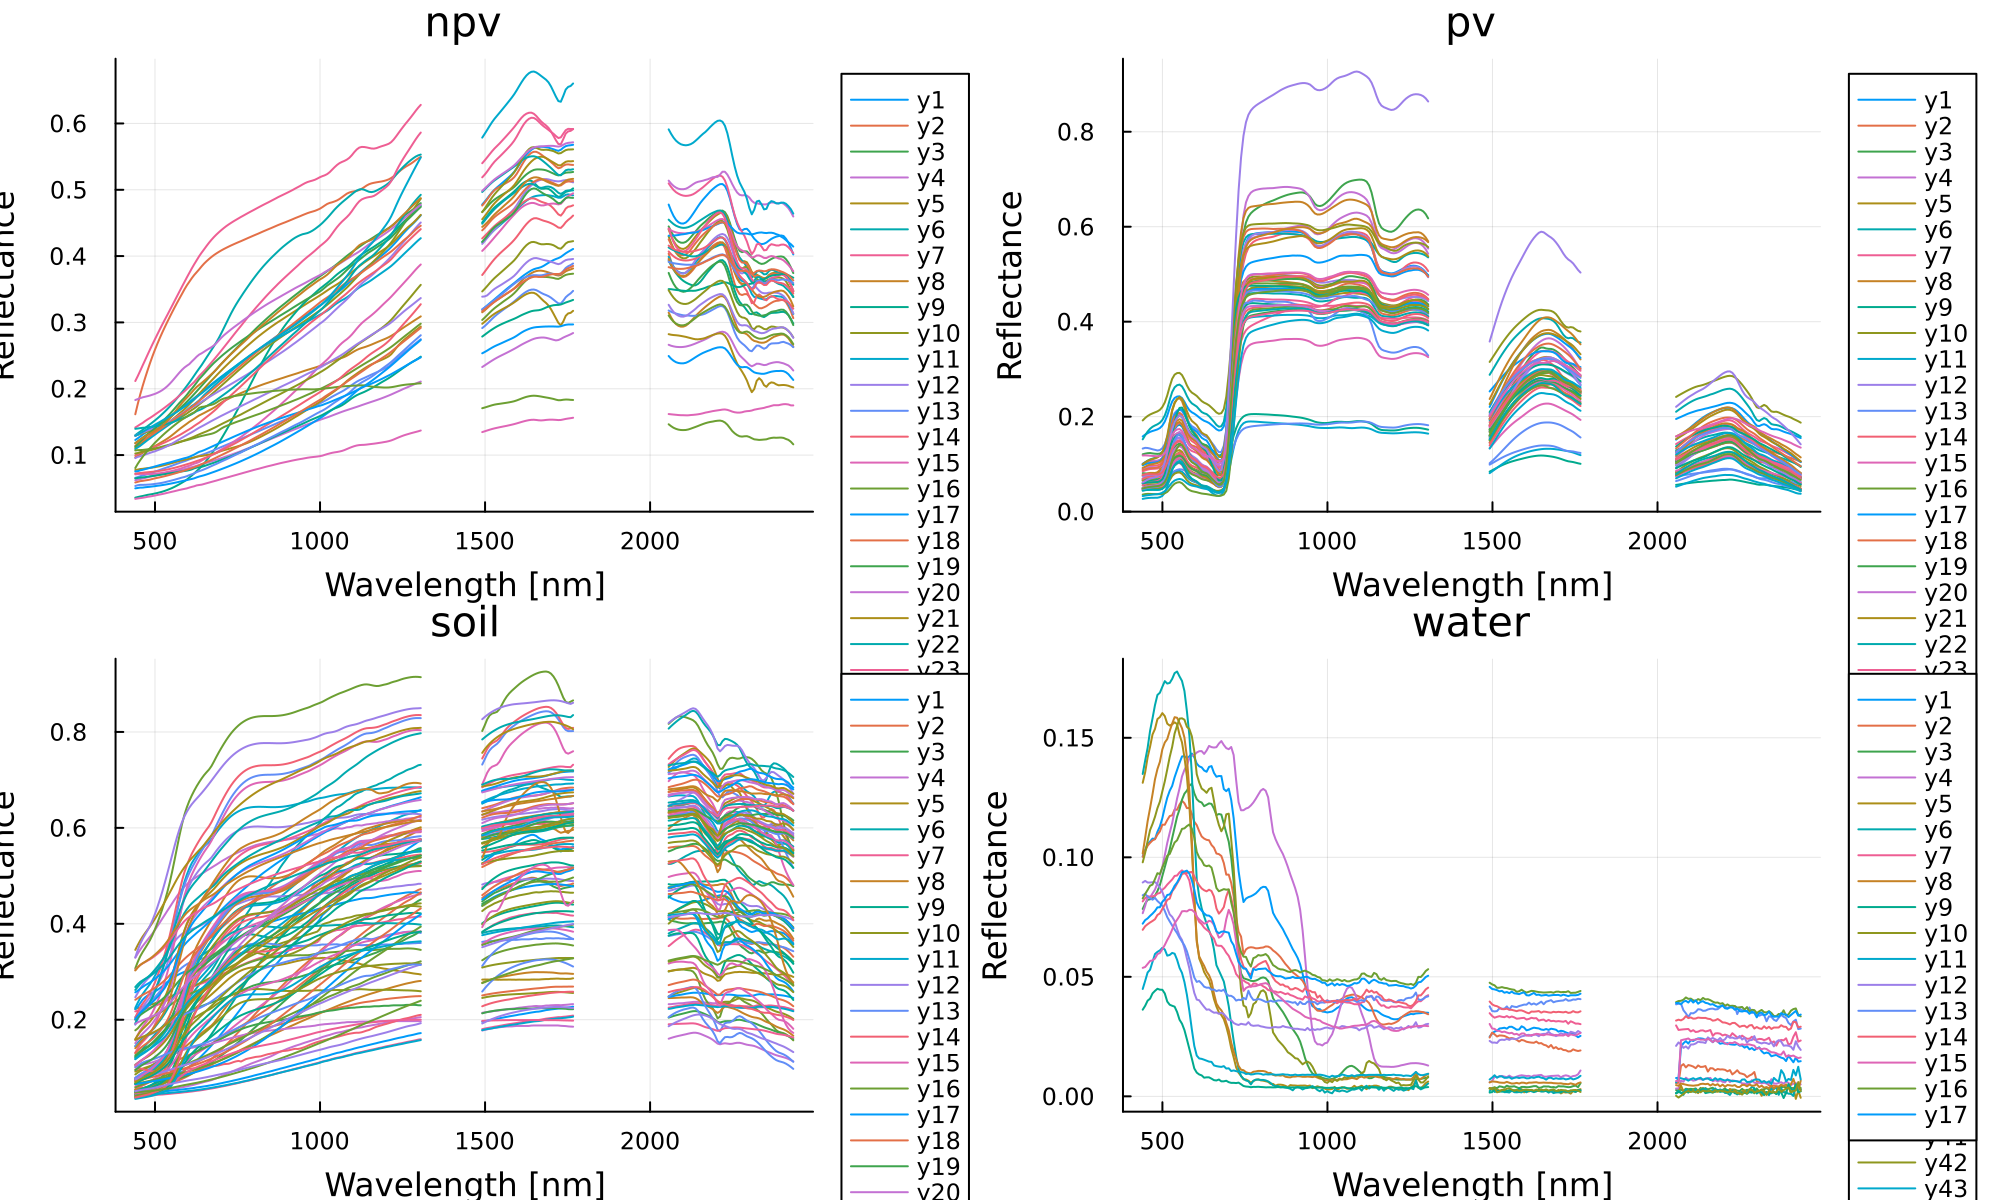

In [11]:
plot_endmembers_individually(endmember_library)

In [12]:
println(aviris_library.spectra)


[NaN NaN NaN NaN NaN NaN NaN NaN 0.009780224132335313 0.012789339956487022 0.015290653432934129 0.017616748338722565 0.020102038569799995 0.02174502824850299 0.023223547967065866 0.024999037104391223 0.02755274444171656 0.030257983847704586 0.033687267768063855 0.03776778201696609 0.04216320261137728 0.04613142046586829 0.049055264513800004 0.051126004708582855 0.052361925751497014 0.05257450508922156 0.05212279120598802 0.051612997935728544 0.05117544926666667 0.05117226700199601 0.050409229305389214 0.049714386720159674 0.049249098039599995 0.04973714797185629 0.05021480436726547 0.04964982639481039 0.04863972358822355 0.04726713008922156 0.044843998253293396 0.04313868306067864 0.04280455836706588 0.046809751458682686 0.055892077482800145 0.06985416156167684 0.0852507308279441 0.10111541477065872 0.1194231392538922 0.13614138483712568 0.1517628289167664 0.1634681445111777 0.17137143915668662 0.17763151892954093 0.17758701875920002 0.18206189662834332 0.1860084858814371 0.18914336924

In [4]:
import ArchGDAL
import GDAL
function load_line(reflectance_file::String, reflectance_uncertainty_file::String, line::Int64,
    good_bands::Array{Bool}, refl_nodata::Float64)

reflectance_dataset = ArchGDAL.read(reflectance_file)
img_dat = convert(Array{Float64},ArchGDAL.readraster(reflectance_file)[:,line,:])
img_dat = img_dat[:, good_bands]
good_data = .!all(img_dat .== refl_nodata, dims=2)[:,1]
img_dat = img_dat[good_data,:]

if sum(good_data) >= 1
if reflectance_uncertainty_file != ""
unc_dat = convert(Array{Float64},ArchGDAL.readraster(reflectance_uncertainty_file)[:,line,:])
unc_dat = unc_dat[:, good_bands]
unc_dat = unc_dat[good_data,:]
else
unc_dat = nothing
end
else
return nothing, nothing, good_data
end

return img_dat, unc_dat, good_data
end

load_line (generic function with 1 method)

In [5]:
img_dat, unc_dat, good_data = load_line("subset_npv_bil", "subset_npv_bil", 1, endmember_library.good_bands, -9999.0)

([0.4802907407283783 0.49060508608818054 … 0.48820146918296814 0.4850459694862366; 0.5111842155456543 0.5210517644882202 … 0.49243295192718506 0.4832092225551605; … ; 0.5258935689926147 0.5357292294502258 … 0.4774639904499054 0.4740636348724365; 0.5239952206611633 0.5354686975479126 … 0.4822336435317993 0.47646331787109375], [0.4802907407283783 0.49060508608818054 … 0.48820146918296814 0.4850459694862366; 0.5111842155456543 0.5210517644882202 … 0.49243295192718506 0.4832092225551605; … ; 0.5258935689926147 0.5357292294502258 … 0.4774639904499054 0.4740636348724365; 0.5239952206611633 0.5354686975479126 … 0.4822336435317993 0.47646331787109375], Bool[1, 1, 1, 1, 1])

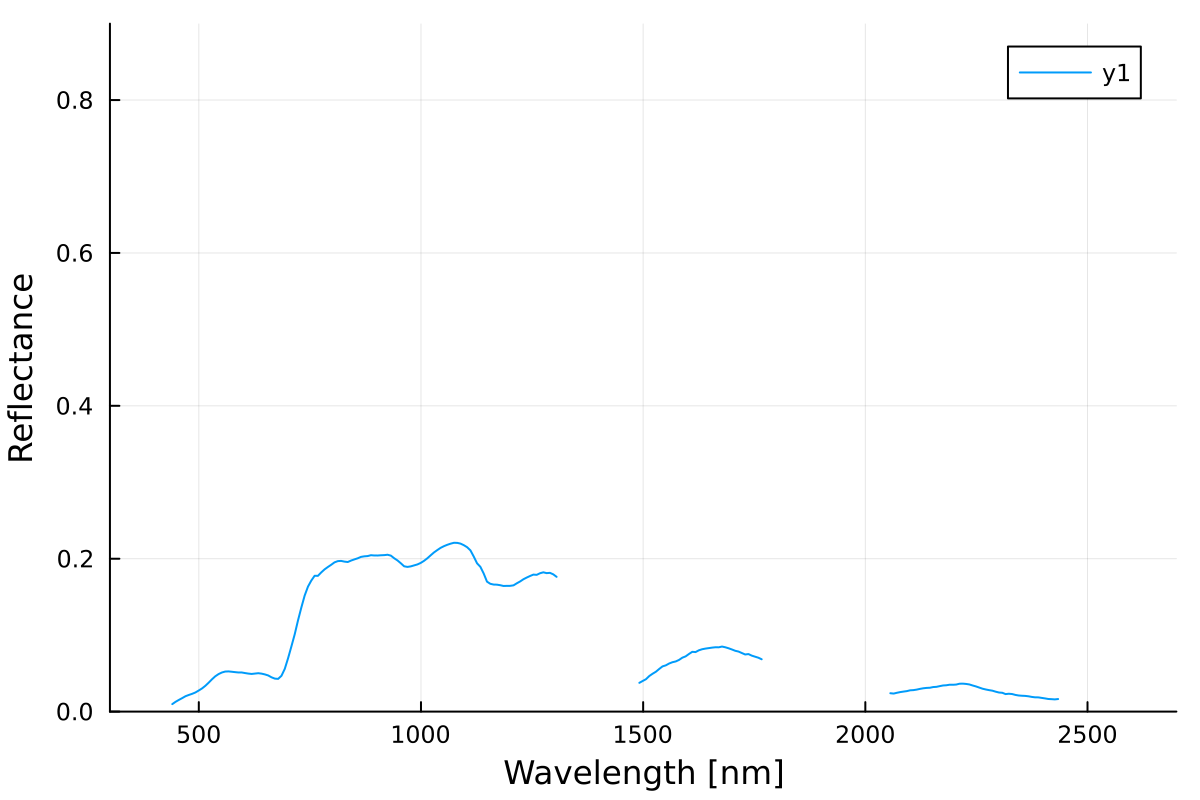

In [20]:

full_rfl = ones(size(endmember_library.wavelengths))
full_rfl[endmember_library.good_bands] = aviris_library.spectra[aviris_library.good_bands]
aviris_library.spectra=aviris_library.spectra[aviris_library.good_bands]
plot(endmember_library.wavelengths, full_rfl, xlim=[300,2700])

xlabel!("Wavelength [nm]")
ylabel!("Reflectance")
xticks!([500, 1000, 1500, 2000, 2500])
ylims!(0,0.9)
plot!(dpi=200)
plot!()


In [22]:
n_mc = 25
mode = "sma-best"
num_endmembers=[30]
normalization="500"
#normalization="brightness"
optimization="bvls"

max_combinations=1000
combination_type="class-even"

unmixing_library = endmember_library

class_idx = prepare_combinations(unmixing_library, combination_type)
options = prepare_options(unmixing_library, combination_type, num_endmembers, class_idx)

mr, mv, cfr, cfv = unmix_pixel(unmixing_library, aviris_library.spectra, nothing, class_idx, 									options, mode, n_mc, 
            num_endmembers, normalization, optimization, max_combinations, combination_type);
println(mr)
println(mv)

[0.0, 0.6785961390729413, 0.0, 0.32140386092705886, 0.06718200094278846]
[0.0, 0.1438501358127917, 0.0, 0.14385013581279174, 0.0040684387224010025]


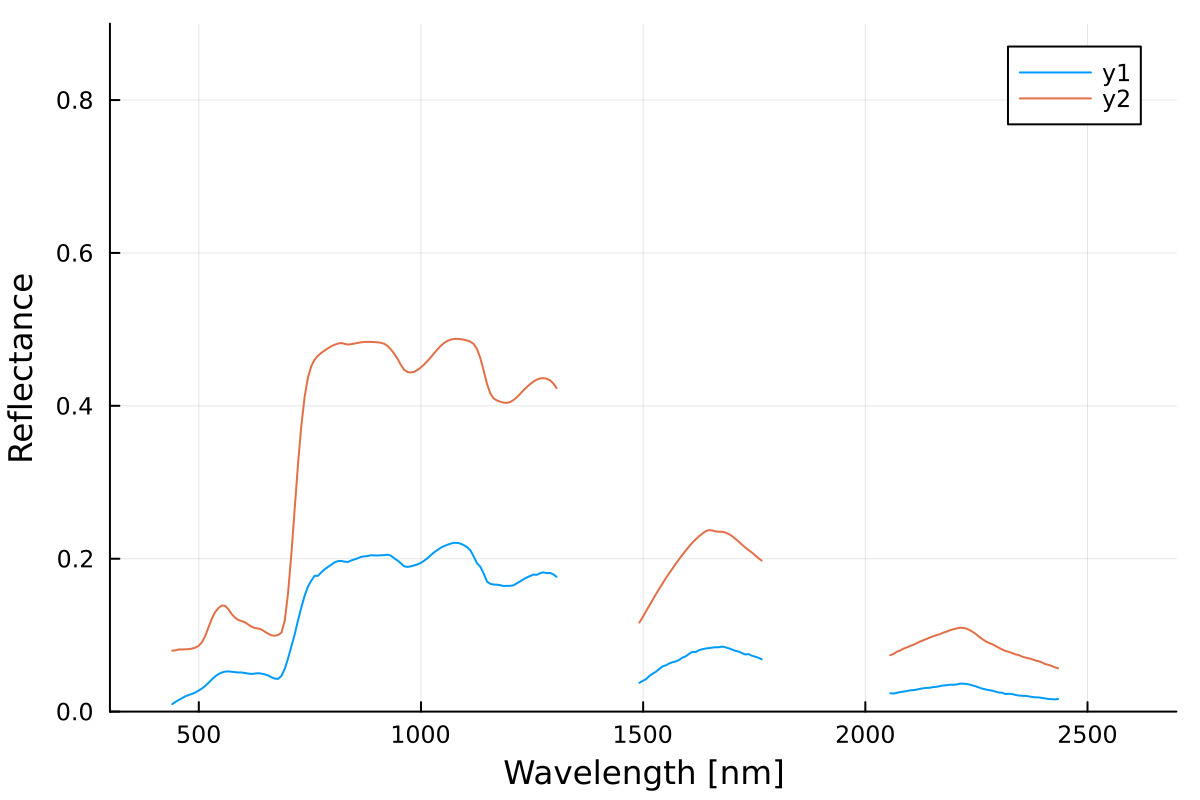

In [24]:
model_rfl = cfr[1:end-1,:]' * endmember_library.spectra

full_rfl = ones(size(endmember_library.wavelengths))
full_rfl[:] .= NaN
full_rfl[endmember_library.good_bands] = aviris_library.spectra
plot(endmember_library.wavelengths, full_rfl, xlim=[300,2700])
plot!(endmember_library.wavelengths, model_rfl[1,:], xlim=[300,2700])

xlabel!("Wavelength [nm]")
ylabel!("Reflectance")
xticks!([500, 1000, 1500, 2000, 2500])
ylims!(0,0.9)
plot!(dpi=200)
plot!()

In [26]:
output = scale_data(reshape(full_rfl, 1, length(full_rfl)), endmember_library.wavelengths, "brightness")

1×285 Matrix{Float64}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN

(1, 285)
(285,)
[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.07862377182437949, 0.10281422316271106, 0.12292242286983412, 0.14162203063341328, 0.16160141856988716, 0.17480950499615497, 0.18669540816332258, 0.20096866518901824, 0.22149806209029033, 0.24324563381346873, 0.27081384010681064, 0.3036173236354864, 0.3389523569855499, 0.37085308348417984, 0.39435803021792737, 0.41100482709898234, 0.4209404658692391, 0.42264940312033683, 0.4190180498093388, 0.4149197930397453, 0.41140231468210287, 0.4113767322774498, 0.40524262932237903, 0.39965675070285656, 0.39591626883272835, 0.39983972968530296, 0.4036796363106473, 0.39913774661660173, 0.3910174733478453, 0.3799831170168529, 0.36050342391467505, 0.346794299176981, 0.3441082519743769, 0.3763062244836908, 0.44931955416740693, 0.5615615332833072, 0.6853354194938474, 0.8128725059143865, 0.9600493326329426, 1.0944482490845868, 1.2200299165664448, 1.3141296069185915, 1.3776646370427896, 1.4279897703938784, 1.4276320310218877, 1.4636058258720757, 1

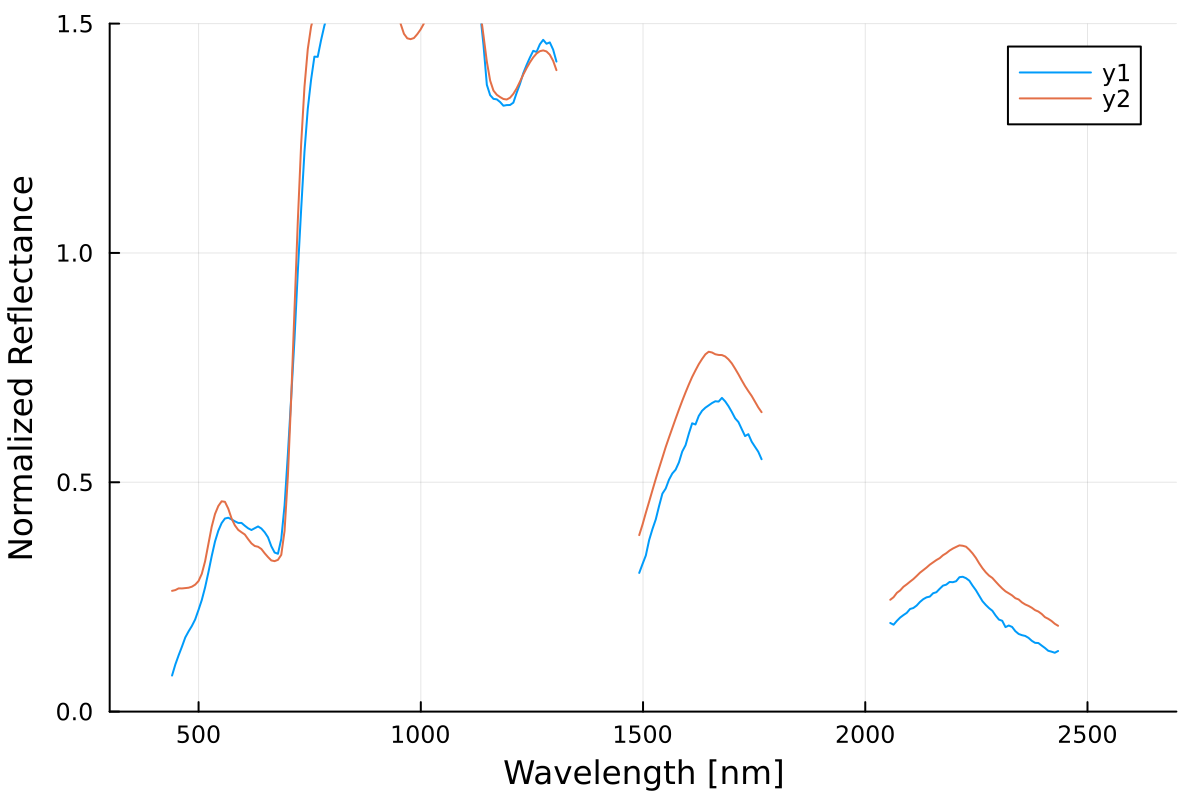

In [30]:
full_rfl_norm = ones(size(endmember_library.wavelengths))
full_rfl_norm[:] .= NaN
full_rfl_norm[endmember_library.good_bands] = scale_data(reshape(aviris_library.spectra, 1, length(aviris_library.spectra)), endmember_library.wavelengths[endmember_library.good_bands], "brightness")

println(size(model_rfl))
model_rfl_norm = ones(size(endmember_library.wavelengths))
model_rfl_norm[:] .= NaN
model_rfl_norm[endmember_library.good_bands] = scale_data(reshape(model_rfl[1,endmember_library.good_bands], 1, length(aviris_library.spectra)) , endmember_library.wavelengths[endmember_library.good_bands], "brightness")


println(size(full_rfl_norm))
print(full_rfl_norm)
plot(endmember_library.wavelengths, full_rfl_norm, xlim=[300,2700])
plot!(endmember_library.wavelengths, model_rfl_norm, xlim=[300,2700])

xlabel!("Wavelength [nm]")
ylabel!("Normalized Reflectance")
xticks!([500, 1000, 1500, 2000, 2500])
ylims!(0,1.5)
plot!(dpi=200)
plot!()

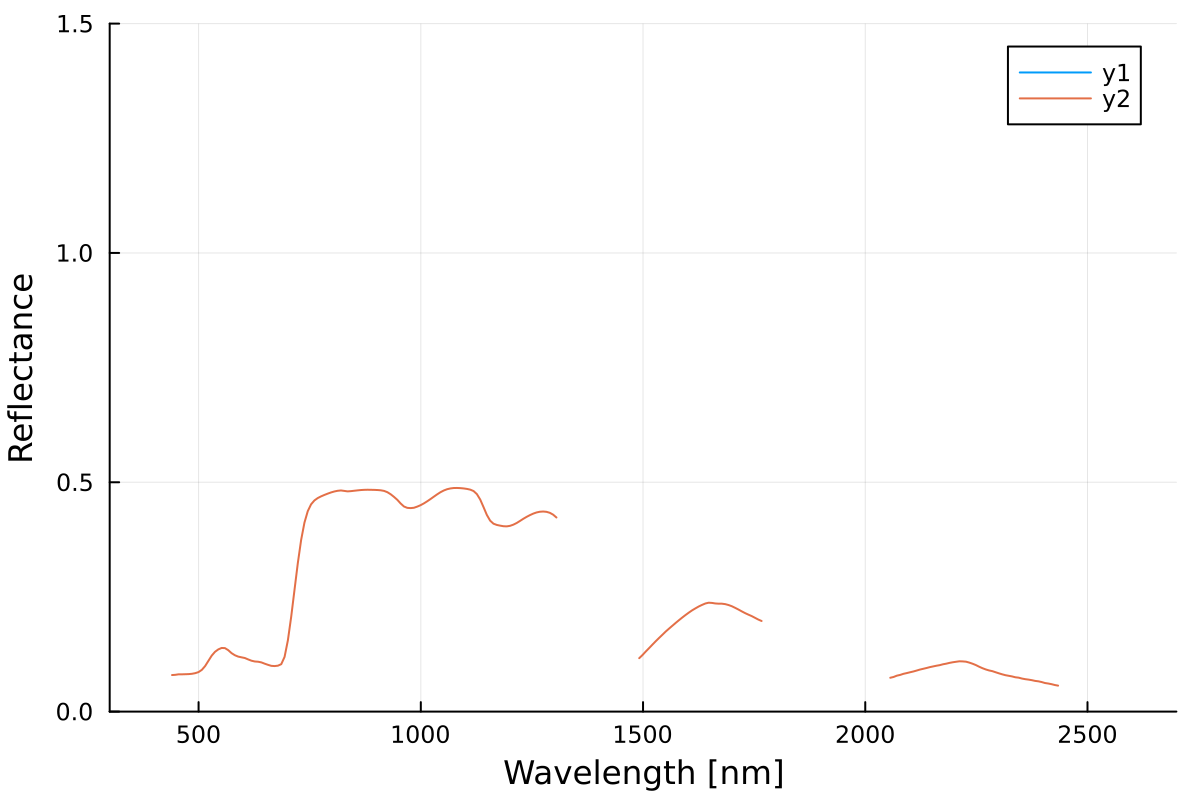

In [31]:
plot(endmember_library.wavelengths, full_rfl[1,:], xlim=[300,2700])
plot!(endmember_library.wavelengths, model_rfl[1,:], xlim=[300,2700])

xlabel!("Wavelength [nm]")
ylabel!("Reflectance")
xticks!([500, 1000, 1500, 2000, 2500])
ylims!(0,1.5)
plot!(dpi=200)
plot!()

In [32]:
println(full_rfl)
println(full_rfl_norm)

[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.009780224132335313, 0.012789339956487022, 0.015290653432934129, 0.017616748338722565, 0.020102038569799995, 0.02174502824850299, 0.023223547967065866, 0.024999037104391223, 0.02755274444171656, 0.030257983847704586, 0.033687267768063855, 0.03776778201696609, 0.04216320261137728, 0.04613142046586829, 0.049055264513800004, 0.051126004708582855, 0.052361925751497014, 0.05257450508922156, 0.05212279120598802, 0.051612997935728544, 0.05117544926666667, 0.05117226700199601, 0.050409229305389214, 0.049714386720159674, 0.049249098039599995, 0.04973714797185629, 0.05021480436726547, 0.04964982639481039, 0.04863972358822355, 0.04726713008922156, 0.044843998253293396, 0.04313868306067864, 0.04280455836706588, 0.046809751458682686, 0.055892077482800145, 0.06985416156167684, 0.0852507308279441, 0.10111541477065872, 0.1194231392538922, 0.13614138483712568, 0.1517628289167664, 0.1634681445111777, 0.17137143915668662, 0.17763151892954093, 0.17758701875920002,

In [33]:
findall(cfr[1:end-1] .!= 0)

2-element Vector{Int64}:
  37
 178

In [34]:
size(endmember_library.spectra)

(191, 285)

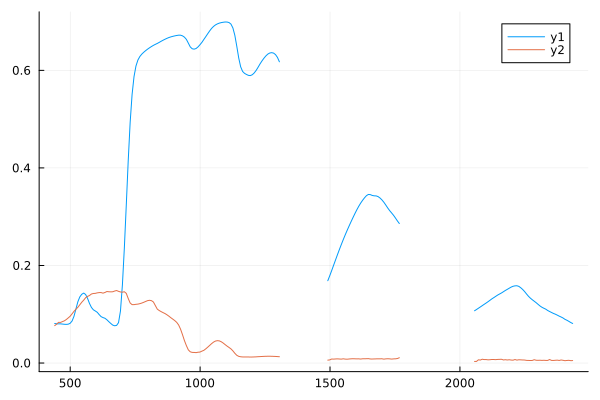

In [35]:
plot(endmember_library.wavelengths, endmember_library.spectra[findall(cfr[1:end-1] .!= 0),:]')

In [36]:
println(full_rfl_norm)

[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.07862377182437949, 0.10281422316271106, 0.12292242286983412, 0.14162203063341328, 0.16160141856988716, 0.17480950499615497, 0.18669540816332258, 0.20096866518901824, 0.22149806209029033, 0.24324563381346873, 0.27081384010681064, 0.3036173236354864, 0.3389523569855499, 0.37085308348417984, 0.39435803021792737, 0.41100482709898234, 0.4209404658692391, 0.42264940312033683, 0.4190180498093388, 0.4149197930397453, 0.41140231468210287, 0.4113767322774498, 0.40524262932237903, 0.39965675070285656, 0.39591626883272835, 0.39983972968530296, 0.4036796363106473, 0.39913774661660173, 0.3910174733478453, 0.3799831170168529, 0.36050342391467505, 0.346794299176981, 0.3441082519743769, 0.3763062244836908, 0.44931955416740693, 0.5615615332833072, 0.6853354194938474, 0.8128725059143865, 0.9600493326329426, 1.0944482490845868, 1.2200299165664448, 1.3141296069185915, 1.3776646370427896, 1.4279897703938784, 1.4276320310218877, 1.4636058258720757, 1.495332678827714

In [39]:
for (i, frac) in enumerate(mr)
    if i <= length(endmember_library.class_valid_keys)
        println("Class: ", endmember_library.class_valid_keys[i], " Fractional Abundance: ", frac)
    else
        println("Extra component (e.g., shade or residual): Fractional Abundance: ", frac)
    end
end


Class: npv Fractional Abundance: 0.0
Class: pv Fractional Abundance: 0.6785961390729413
Class: soil Fractional Abundance: 0.0
Class: water Fractional Abundance: 0.32140386092705886
Extra component (e.g., shade or residual): Fractional Abundance: 0.06718200094278846
